In [1]:
import numpy as np
import pandas as pd
import os
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras import backend as K
from tqdm import trange
import tensorflow as tf
import gc

from dataloader import get_data, get_weather, get_hod, get_dow, get_train_set_qra, get_test_set_qra

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

Using TensorFlow backend.


In [2]:
def qloss(y_true, y_pred, q):
    tmp1 = (q / 100 - 1) * (y_true - y_pred)
    tmp2 = q / 100 * (y_true - y_pred)
    return K.mean(K.maximum(tmp1, tmp2))

In [3]:
data_set = 'London_2013'
path = os.path.abspath(os.path.join(os.getcwd(), '../..'))

data = get_data(path, data_set)

100%|██████████| 2002/2002 [01:03<00:00, 31.39it/s]


In [4]:
def qloss(y_true, y_pred, q):
    tmp1 = (q / 100 - 1) * (y_true - y_pred)
    tmp2 = q / 100 * (y_true - y_pred)
    return K.mean(K.maximum(tmp1, tmp2))

def train_model_1(train, test, week, day):
    
    # to get the num of samples
    max_lag = 24
    max_d = 2
    trainX, trainTlag, trainTd, trainY = get_train_set_qra(train, week, day, max_lag, max_d)
    n_samples = trainY.shape[0]
    
    error_train_step1 = np.zeros((24, 2))
    error_test_step1 = np.zeros((24, 2))
    pred_train = np.zeros((24, 2, n_samples))
    pred_test = np.zeros((24, 2, 168))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=50)

    for lag in trange(1, 25):
        for d in range(1, 3):
            trainX, trainTlag, trainTd, trainY = get_train_set_qra(train, week, day, lag, d)
            testX, testTlag, testTd, testY = get_test_set_qra(train, test, week, day, lag, d)

            ## QRA step 1
            # linear model
            inputs = Input((7 + 24 + 3 + lag*3 + d*3,), name='input')
            x = Dense(1, use_bias=True, kernel_initializer='he_normal', bias_initializer='he_normal')(inputs)
            model = Model(inputs=inputs, outputs=x)

            # Train
            model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
            hist1 = model.fit(x=np.hstack((trainX, trainTlag, trainTd)), y=trainY, validation_split=0.2, epochs=1500, verbose=0, callbacks=[early_stopping])

            # Predict (train)
            pred = model.predict(x=np.hstack((trainX, trainTlag, trainTd)))
            error_train_step1[lag-1, d-1] = np.sum(np.abs(pred[-n_samples:, :] - trainY[-n_samples:, :]))
            pred_train[lag-1, d-1] = np.squeeze(pred[-n_samples:, :])

            # Predict (test)
            pred = model.predict(x=np.hstack((testX, testTlag, testTd)))
            error_test_step1[lag-1, d-1] = np.sum(np.abs(pred - testY))
            pred_test[lag-1, d-1] = np.squeeze(pred)

    # clear
    del model, pred, hist1
    tf.keras.backend.clear_session()
    gc.collect()
    return pred_train, pred_test, trainY[-n_samples:, :], testY
#     return error_train_step1, error_test_step1

def train_model_2(trainX, trainY, testX, num_best):
    
    total_pred = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    
    for q in trange(1, 100):
        
        input_dim = num_best
        model = Sequential([Dense(1, use_bias=True, kernel_initializer='he_normal', bias_initializer='he_normal', input_shape=(input_dim,))])

        # Train
        model.compile(loss=lambda y_true, y_pred: qloss(y_true, y_pred, q), optimizer='adam')
        hist2 = model.fit(x=trainX, y=trainY, validation_split=0.2, epochs=1500, verbose=0, callbacks=[early_stopping])

        # Predict (test)
        pred = model.predict(x=testX)
        total_pred.append(np.squeeze(pred))
    
    total_pred = np.array(total_pred)
    
    del model, pred, hist2
    tf.keras.backend.clear_session()
    gc.collect()
    return total_pred

In [5]:
month = 1
n_clusters = 2
method = 'hierarchical/euclidean'

path_cluster = os.path.join(path, 'result', data_set, 'clustering', 'point', method, f'n_clusters_{n_clusters}.csv')
clusters = pd.read_csv(path_cluster, header=None)

series = data[:, month-1, :months[month-1]*24]
weather = get_weather(path, data_set, month)
week = get_dow(data_set, month)
day = get_hod(month)

In [7]:
for i in range(n_clusters):

    index = list(clusters[month-1] == i)
    sub_series = series[index]
    sub_series = np.sum(sub_series, axis=0)

    total_series = np.vstack((sub_series, weather))

    test = total_series[:, -168:]
    train = total_series[:, :-168]

    scale = np.zeros(2)
    scale[0] = np.max(train[0])
    scale[1] = np.min(train[0])
    train[0] = (train[0] - scale[1]) / (scale[0] - scale[1])
    test[0] = (test[0] - scale[1]) / (scale[0] - scale[1])

    num_best = 8
    
    trainX_, testX_, trainY_, testY_ = train_model_1(train, test, week, day)
#     error_train, error_test = train_model_1(train, test, week, day)

    error = np.sum(np.abs(trainX_ - np.squeeze(trainY_)), axis=2)
    trainX = np.vstack((trainX_[np.argsort(error[:, 0])[:num_best//2], 0, :], trainX_[np.argsort(error[:, 1])[:num_best//2], 1, :])).T
    trainY = trainY_.copy()
    testX = np.vstack((testX_[np.argsort(error[:, 0])[:num_best//2], 0, :], testX_[np.argsort(error[:, 1])[:num_best//2], 1, :])).T

    pred_series = train_model_2(trainX, trainY, testX, num_best)

    break

100%|██████████| 24/24 [04:17<00:00, 10.78s/it]


In [7]:
np.save('qra_train.npy', error_train)
np.save('qra_test.npy', error_test)

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

train = np.load('qra_train.npy')
test = np.load('qra_test.npy')

In [40]:
train_ = np.sum(train, axis=0)
test_ = np.sum(test, axis=0)

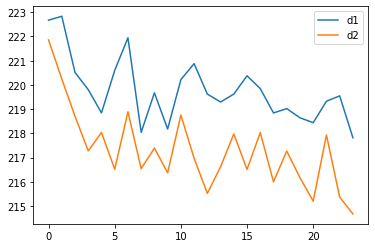

In [43]:
# plt.figure(figsize=(10,5))
plt.plot(train_[:, 0])
# plt.plot(test_[:, 0])
plt.plot(train_[:, 1])
# plt.plot(test_[:, 1])
plt.legend(['d1', 'd2'], loc='upper right')